In [14]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


In [15]:
def set_leaf(leaf_class, tree_):
    tree_.is_leaf = True  
    tree_.leaf_class = leaf_class
    tree_.feature_name = None
    tree_.feature_index = None
    tree_.subtree = {}
    tree_.impurity = None
    tree_.split_value = None
    tree_.high = 0  
    tree_.leaf_num = 1


def val_accuracy_after_split(feature_train, y_train, feature_val, y_val, split_value=None):
    if split_value is not None:
        def split_fun(x):
            if x >= split_value:
                return '>= {:.3f}'.format(split_value)
            else:
                return '< {:.3f}'.format(split_value)

        train_split = feature_train.map(split_fun)
        val_split = feature_val.map(split_fun)

    else:
        train_split = feature_train
        val_split = feature_val

    majority_class_in_train = y_train.groupby(train_split).apply(
        lambda x: pd.value_counts(x).index[0])  # 计算各特征下样本最多的类别
    right_class_in_val = y_val.groupby(val_split).apply(
        lambda x: np.sum(x == majority_class_in_train[x.name]))  # 计算各类别对应的数量

    return right_class_in_val.sum() / y_val.shape[0]  # 返回准确率
    
def post_pruning(X_train, y_train, X_val, y_val, tree_=None):
    if tree_.is_leaf:
        return tree_

    if X_val.empty:         # 验证集为空集时，不再剪枝
        return tree_

    most_common_in_train = pd.value_counts(y_train).index[0]
    current_accuracy = np.mean(y_val == most_common_in_train)  # 当前节点下验证集样本准确率


    up_part_train = X_train.loc[:, tree_.feature_name] >= tree_.split_value
    down_part_train = X_train.loc[:, tree_.feature_name] < tree_.split_value
    up_part_val = X_val.loc[:, tree_.feature_name] >= tree_.split_value
    down_part_val = X_val.loc[:, tree_.feature_name] < tree_.split_value

    up_subtree = post_pruning(X_train[up_part_train], y_train[up_part_train], X_val[up_part_val],
                                  y_val[up_part_val],
                                  tree_.subtree['>= {:.3f}'.format(tree_.split_value)])
    tree_.subtree['>= {:.3f}'.format(tree_.split_value)] = up_subtree
    down_subtree = post_pruning(X_train[down_part_train], y_train[down_part_train],
                                    X_val[down_part_val], y_val[down_part_val],
                                    tree_.subtree['< {:.3f}'.format(tree_.split_value)])
    tree_.subtree['< {:.3f}'.format(tree_.split_value)] = down_subtree

    tree_.high = max(up_subtree.high, down_subtree.high) + 1
    tree_.leaf_num = (up_subtree.leaf_num + down_subtree.leaf_num)

    if up_subtree.is_leaf and down_subtree.is_leaf:
        def split_fun(x):
            if x >= tree_.split_value:
                return '>= {:.3f}'.format(tree_.split_value)
            else:
                return '< {:.3f}'.format(tree_.split_value)

        val_split = X_val.loc[:, tree_.feature_name].map(split_fun)
        right_class_in_val = y_val.groupby(val_split).apply(
            lambda x: np.sum(x == tree_.subtree[x.name].leaf_class))
        split_accuracy = right_class_in_val.sum() / y_val.shape[0]

        if current_accuracy > split_accuracy:  
            set_leaf(pd.value_counts(y_train).index[0], tree_)

    return tree_



decision_node = dict(boxstyle='round,pad=0.3', fc='#FAEBD7')
leaf_node = dict(boxstyle='round,pad=0.3', fc='#F4A460')
arrow_args = dict(arrowstyle="<-")

y_off = None
x_off = None
total_num_leaf = None
total_high = None


def plot_node(node_text, center_pt, parent_pt, node_type, ax_):
    ax_.annotate(node_text, xy=[parent_pt[0], parent_pt[1] - 0.02], xycoords='axes fraction',
                 xytext=center_pt, textcoords='axes fraction',
                 va="center", ha="center", size=5,
                 bbox=node_type, arrowprops=arrow_args)


def plot_mid_text(mid_text, center_pt, parent_pt, ax_):
    x_mid = (parent_pt[0] - center_pt[0]) / 2 + center_pt[0]
    y_mid = (parent_pt[1] - center_pt[1]) / 2 + center_pt[1]
    ax_.text(x_mid, y_mid, mid_text, fontdict=dict(size=5))#fff


def plot_tree(my_tree, parent_pt, node_text, ax_):
    global y_off
    global x_off
    global total_num_leaf
    global total_high

    num_of_leaf = my_tree.leaf_num
    center_pt = (x_off + (1 + num_of_leaf) / (2 * total_num_leaf), y_off)

    plot_mid_text(node_text, center_pt, parent_pt, ax_)

    if total_high == 0:  
        plot_node(my_tree.leaf_class, center_pt, parent_pt, leaf_node, ax_)
        return
    plot_node(my_tree.feature_name, center_pt, parent_pt, decision_node, ax_)

    y_off -= 1 / total_high
    for key in my_tree.subtree.keys():
        if my_tree.subtree[key].is_leaf:
            x_off += 1 / total_num_leaf
            plot_node(str(my_tree.subtree[key].leaf_class), (x_off, y_off), center_pt, leaf_node, ax_)
            plot_mid_text(str(key), (x_off, y_off), center_pt, ax_)
        else:
            plot_tree(my_tree.subtree[key], center_pt, str(key), ax_)
    y_off += 1 / total_high


def create_plot(tree_):
    global y_off
    global x_off
    global total_num_leaf
    global total_high

    total_num_leaf = tree_.leaf_num
    total_high = tree_.high
    y_off = 1
    x_off = -0.5 / total_num_leaf

    fig_, ax_ = plt.subplots()
    ax_.set_xticks([])  # 隐藏坐标轴刻度
    ax_.set_yticks([])
    ax_.spines['right'].set_color('none')  # 设置隐藏坐标轴
    ax_.spines['top'].set_color('none')
    ax_.spines['bottom'].set_color('none')
    ax_.spines['left'].set_color('none')
    plot_tree(tree_, (0.5, 1), '', ax_)

    plt.show()

0.7302631578947368


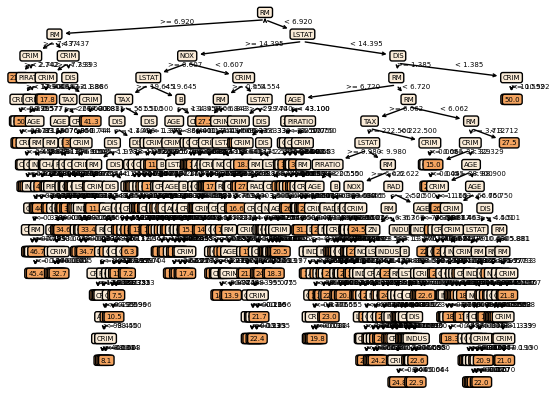

In [16]:
class Node(object):
    def __init__(self):
        self.feature_name = None
        self.feature_index = None
        self.subtree = {}
        self.impurity = None
        self.is_continuous = False
        self.split_value = None
        self.is_leaf = False
        self.leaf_class = None
        self.leaf_num = None
        self.high = -1


class DecisionTree(object):

    def __init__(self, prun):
        self.prun = prun
        #默认采用gini post_pruning

    def fit(self, X_train, y_train, X_val=None, y_val=None):

        X_train.reset_index(inplace=True, drop=True)
        y_train.reset_index(inplace=True, drop=True)

        if X_val is not None:
            X_val.reset_index(inplace=True, drop=True)
            y_val.reset_index(inplace=True, drop=True)

        self.columns = list(X_train.columns)  # 包括原数据的列名
        self.tree_ = self.generate_tree(X_train, y_train)

        #post pruning
        if self.prun:
            post_pruning(X_train, y_train, X_val, y_val, self.tree_)

        return self

    def generate_tree(self, X, y):
        my_tree = Node()
        my_tree.leaf_num = 0
        if y.nunique() == 1:  # 属于同一类别
            my_tree.is_leaf = True
            my_tree.leaf_class = y.values[0]
            my_tree.high = 0
            my_tree.leaf_num += 1
            return my_tree

        if X.empty:  # 特征用完了，数据为空，返回样本数最多的类
            my_tree.is_leaf = True
            my_tree.leaf_class = pd.value_counts(y).index[0]
            my_tree.high = 0
            my_tree.leaf_num += 1
            return my_tree

        #best_feature_name, best_impurity = self.choose_best_feature_to_split(X, y)
        best_feature_name, best_impurity = self.choose_best_feature_MSE(X, y)

        my_tree.feature_name = best_feature_name
        my_tree.impurity = best_impurity[0]
        my_tree.feature_index = self.columns.index(best_feature_name)

        feature_values = X.loc[:, best_feature_name]

        if len(best_impurity) == 1:  # 离散值
            my_tree.is_continuous = False

            unique_vals = pd.unique(feature_values)
            sub_X = X.drop(best_feature_name, axis=1)

            max_high = -1
            for value in unique_vals:
                my_tree.subtree[value] = self.generate_tree(sub_X[feature_values == value], y[feature_values == value])
                if my_tree.subtree[value].high > max_high:  # 记录子树下最高的高度
                    max_high = my_tree.subtree[value].high
                my_tree.leaf_num += my_tree.subtree[value].leaf_num

            my_tree.high = max_high + 1

        elif len(best_impurity) == 2:  # 连续值
            my_tree.is_continuous = True
            my_tree.split_value = best_impurity[1]
            up_part = '>= {:.3f}'.format(my_tree.split_value)
            down_part = '< {:.3f}'.format(my_tree.split_value)

            my_tree.subtree[up_part] = self.generate_tree(X[feature_values >= my_tree.split_value],
                                                          y[feature_values >= my_tree.split_value])
            my_tree.subtree[down_part] = self.generate_tree(X[feature_values < my_tree.split_value],
                                                            y[feature_values < my_tree.split_value])

            my_tree.leaf_num += (my_tree.subtree[up_part].leaf_num + my_tree.subtree[down_part].leaf_num)

            my_tree.high = max(my_tree.subtree[up_part].high, my_tree.subtree[down_part].high) + 1

        return my_tree

    def predict(self, X):
        if not hasattr(self, "tree_"):
            raise Exception('you have to fit first before predict.')
        if X.ndim == 1:
            return self.predict_single(X)
        else:
            return X.apply(self.predict_single, axis=1)

    def predict_single(self, x, subtree=None):
        if subtree is None:
            subtree = self.tree_

        if subtree.is_leaf:
            return subtree.leaf_class

        if subtree.is_continuous:  # 若是连续值，需要判断是
            if x[subtree.feature_index] >= subtree.split_value:
                return self.predict_single(x, subtree.subtree['>= {:.3f}'.format(subtree.split_value)])
            else:
                return self.predict_single(x, subtree.subtree['< {:.3f}'.format(subtree.split_value)])
        else:
            return self.predict_single(x, subtree.subtree[x[subtree.feature_index]])


    def choose_best_feature_MSE(self, X, y):
        features = X.columns
        best_feature_name = None
        best_MSE = [float('inf')]
        for feature_name in features:
            MSE_idex = self.MSE_index(X[feature_name], y)
            if MSE_idex[0] < best_MSE[0]:
                best_feature_name = feature_name
                best_MSE = MSE_idex

        return best_feature_name, best_MSE

    def MSE_index(self, feature, y):
        
        m = y.shape[0]
        unique_value = pd.unique(feature)
        
        unique_value.sort()  
        split_point_set = [(unique_value[i] + unique_value[i + 1]) / 2 for i in range(len(unique_value) - 1)]

        min_MSE = float('inf')
        min_MSE_point = None
        for split_point_ in split_point_set: 
            Dv1 = y[feature <= split_point_]
            Dv2 = y[feature > split_point_]
            MSE_index = self.MSE(Dv1) + self.MSE(Dv2)

            if MSE_index < min_MSE:
                min_MSE = MSE_index
                min_MSE_point = split_point_
        return [min_MSE, min_MSE_point]

    def MSE(self, input):
        #print("np.shape(input) is ",np.shape(input)[0])
        avg = np.sum(input)/(np.shape(input)[0])
        res = input - avg
        res = res ** 2
        res = np.sum(res)
        return res



if __name__ == '__main__':

    data = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/boston.csv')
    
    train = range((np.shape(data)[0])-2)
    train = data.sample(frac=0.7).reset_index(drop=True)

    X = train.iloc[:, :13]
    y = train.iloc[:,13]

    test =  data.sample(frac=0.3).reset_index(drop=True)
    X_val = test.iloc[:, :13]
    y_val = test.iloc[:, 13]

    tree = DecisionTree(True)
    tree.fit(X, y, X_val, y_val)

    print(np.sum(tree.predict(X_val) == y_val)/(np.shape(X_val)[0]))
    create_plot(tree.tree_)

0.8589743589743589


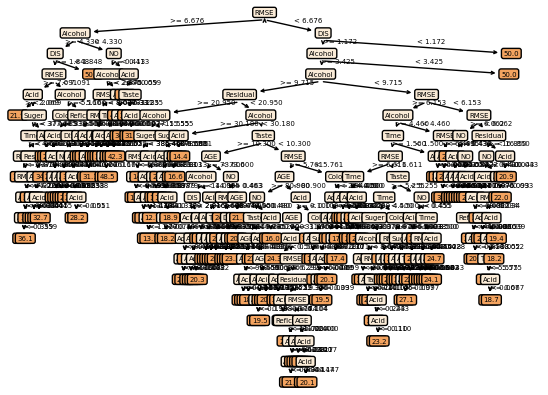

In [17]:
if __name__ == '__main__':

    data = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/winequality-red.csv')
    
    #train = range(int((np.shape(data)[0])/3)*2)

    train = range((np.shape(data)[0])-2)
    train = data.sample(frac=0.8).reset_index(drop=True)
    #print(train)
    #train = [1, 2, 3, 6, 7, 10, 14, 15, 16, 17]
    #train = [i for i in train]
    #X = data.iloc[train, :4]
    #y = data.iloc[train, 4]
    #print(train)
    X = train.iloc[:, :13]
    y = train.iloc[:,13]
    #print(X)
    #print(y)


    ##test = [i - 1 for i in test]
    test =  data.sample(frac=0.3).reset_index(drop=True)
    X_val = test.iloc[:, :13]
    y_val = test.iloc[:, 13]

    tree = DecisionTree(True)
    tree.fit(X, y, X_val, y_val)

    print(np.sum(tree.predict(X_val) == y_val)/(np.shape(X_val)[0]))
    create_plot(tree.tree_)